### 한국어 감성 분석

In [75]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, tensorflow as tf, warnings

warnings.filterwarnings("ignore")

### Get Dataset
영화 리뷰 점수가 매겨진 데이터셋을 가져온다. 1~10점으로 구성되어 있으나, 5~8점은 사용하지 않고, 9~10점을 긍정, 1~4점을 부정으로 분류한 데이터이다.

In [76]:
train_file = tf.keras.utils.get_file("rating_train.txt", origin = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", extract = True)
train = pd.read_csv(train_file, sep = "\t")

### EDA(탐색적 데이터 분석)
간단한 탐색적 데이터 분석을 통해 데이터 파악 및 전처리가 필요한 부분을 찾아본다. 데이터 크기 및 샘플 확인부터 시작해서 레이블 비율, 결측치, 각 레이블 별 텍스트 길이 등을 확인한다. 

In [77]:
# 데이터 크기 및 샘플 확인
print(f"train shape : {train.shape}")
train.head() # 고유 식별 번호, 댓글 내용과 라벨링된 컬럼 3개가 존재한다.

train shape : (150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [78]:
# 레이블 별 개수
train["label"].value_counts() # 0은 부정, 1은 긍정을 의미하며 각 데이터는 75173, 74827개가 존재한다.

0    75173
1    74827
Name: label, dtype: int64

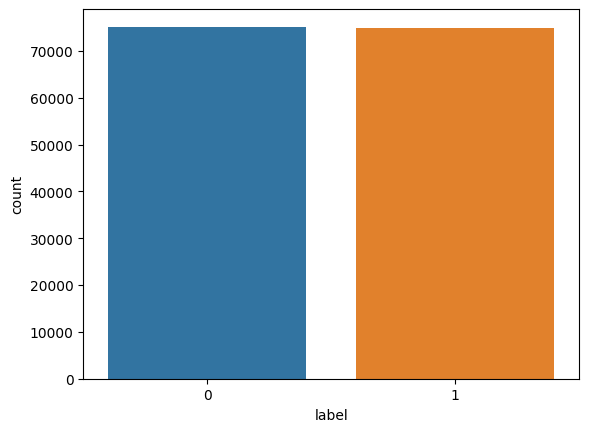

In [79]:
# 레이블 별 개수 분포 시각화
sns.countplot(x = "label", data = train)
plt.show()

In [80]:
# 결측치 개수 확인
train.isna().sum() # 댓글 원문을 의미하는 document 라벨 내부에 5개의 결측치가 있음이 확인된다.
                   # 이는 차후 훈련 시 의미가 없는 데이터이기에 해당 행을 삭제하며 훈련한다.

id          0
document    5
label       0
dtype: int64

In [81]:
# 결측치 행만 따로 모아서 확인하기
train[train["document"].isna() == True]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


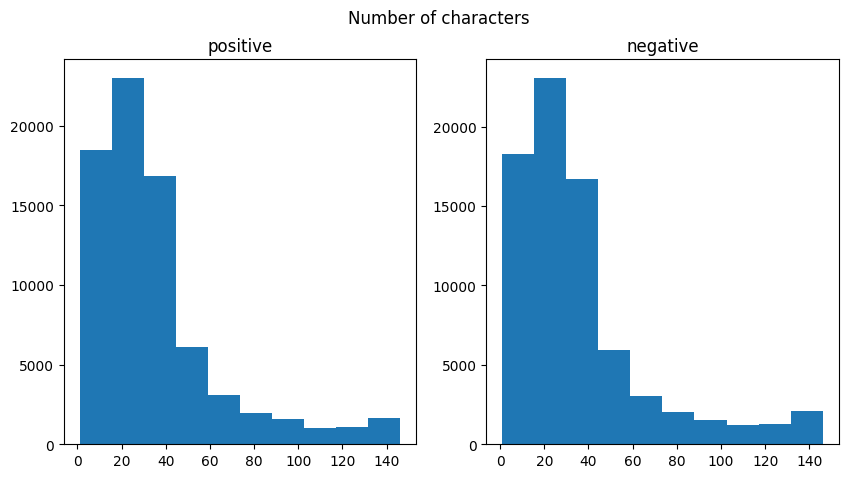

In [82]:
# 레이블 별 텍스트의 길이 확인
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
data_len = train[train["label"]==1]['document'].str.len()
ax1.hist(data_len)
ax1.set_title("positive")

data_len = train[train["label"]==0]['document'].str.len()
ax2.hist(data_len)
ax2.set_title("negative")
fig.suptitle("Number of characters")
plt.show()

### 한글 형태소 분석기 불러오기
영어는 띄어쓰기가 잘 되어 있는 편이지만 한글은 띄어쓰기, 맞춤법 등이 잘못된 경우 분리에 어려움이 있다. 또한 정확한 형태소 분석을 위해서는 데이터에 따라 전처리 과정 등이 필요할 수 있다.

In [83]:
import konlpy
from konlpy.tag import Kkma, Komoran, Okt
from eunjeon import Mecab

kkma = Kkma()
komoran = Komoran()
okt = Okt()
mecab = Mecab()

In [84]:
# 형태소 별 샘플
text = "헌우야안녕오늘날씨어때?"

def sample_ko_pos(text):
    print(f"===={text}====")
    print(f"kkma : {kkma.pos(text)}")
    print(f"komoran : {komoran.pos(text)}")
    print(f"okt : {okt.pos(text)}")
    print(f"mecab : {mecab.pos(text)}")

sample_ko_pos(text)

====헌우야안녕오늘날씨어때?====
kkma : [('헐', 'VV'), ('ㄴ', 'ETD'), ('우', 'NNG'), ('야', 'JX'), ('안녕', 'NNG'), ('오늘날', 'NNG'), ('씨', 'NNB'), ('어', 'VV'), ('어', 'ECS'), ('때', 'NNG'), ('?', 'SF')]
komoran : [('헌', 'MM'), ('우', 'NNP'), ('야', 'NNG'), ('안녕', 'NNP'), ('오늘날', 'NNP'), ('씨', 'NNB'), ('어떻', 'VA'), ('어', 'EF'), ('?', 'SF')]
okt : [('헌우야', 'Verb'), ('안녕', 'Noun'), ('오늘날', 'Noun'), ('씨', 'Suffix'), ('어때', 'Adjective'), ('?', 'Punctuation')]
mecab : [('헌', 'MM'), ('우야', 'NNG'), ('안녕', 'NNG'), ('오늘', 'NNG'), ('날씨', 'NNG'), ('어때', 'VA+EF'), ('?', 'SF')]


In [85]:
# "안뇽"이라는 단어를 신조어 또는 맞춤법이 틀린 단어라고 한다면, komoran과 mecab은 제대로 형태소를 분리하지 못하는 것을 볼 수 있다.
text2 = "헌우야안뇽오늘날씨어때?"
sample_ko_pos(text2)

====헌우야안뇽오늘날씨어때?====
kkma : [('헐', 'VV'), ('ㄴ', 'ETD'), ('우', 'NNG'), ('야안', 'NNG'), ('뇽', 'UN'), ('오늘날', 'NNG'), ('씨', 'NNB'), ('어', 'VV'), ('어', 'ECS'), ('때', 'NNG'), ('?', 'SF')]
komoran : [('헌우야안뇽오늘날씨어때?', 'NA')]
okt : [('헌우야', 'Verb'), ('안뇽', 'Noun'), ('오늘날', 'Noun'), ('씨', 'Suffix'), ('어때', 'Adjective'), ('?', 'Punctuation')]
mecab : [('헌', 'MM'), ('우야', 'NNG'), ('안', 'MAG'), ('뇽오늘날씨어때', 'UNKNOWN'), ('?', 'SF')]


In [86]:
# 일반적으로 형태소 분리의 결과가 모델 성능에 큰 영향을 줄 수 있다. 따라서 띄어쓰기와 맞춤법에 맞는 문장으로 이루어진다면 좋은 성능을 기대할 수 있다.
text3 = "정말 재미있고 매력적인 영화에요 추천합니다."
sample_ko_pos(text3)

====정말 재미있고 매력적인 영화에요 추천합니다.====
kkma : [('정말', 'MAG'), ('재미있', 'VA'), ('고', 'ECE'), ('매력적', 'NNG'), ('이', 'VCP'), ('ㄴ', 'ETD'), ('영화', 'NNG'), ('에', 'JKM'), ('요', 'JX'), ('추천', 'NNG'), ('하', 'XSV'), ('ㅂ니다', 'EFN'), ('.', 'SF')]
komoran : [('정말', 'MAG'), ('재미있', 'VA'), ('고', 'EC'), ('매력', 'NNG'), ('적', 'XSN'), ('이', 'VCP'), ('ㄴ', 'ETM'), ('영화', 'NNG'), ('에', 'JKB'), ('요', 'JX'), ('추천', 'NNG'), ('하', 'XSV'), ('ㅂ니다', 'EF'), ('.', 'SF')]
okt : [('정말', 'Noun'), ('재미있고', 'Adjective'), ('매력', 'Noun'), ('적', 'Suffix'), ('인', 'Josa'), ('영화', 'Noun'), ('에요', 'Josa'), ('추천', 'Noun'), ('합니다', 'Verb'), ('.', 'Punctuation')]
mecab : [('정말', 'MAG'), ('재미있', 'VA'), ('고', 'EC'), ('매력', 'NNG'), ('적', 'XSN'), ('인', 'VCP+ETM'), ('영화', 'NNG'), ('에', 'JKB'), ('요', 'MM'), ('추천', 'NNG'), ('합니다', 'XSV+EF'), ('.', 'SF')]


### 데이터 전처리
탐색적 데이터 분석 결과 특수문자, 숫자 등이 포함되어 있음을 발견할 수 있었다.

In [87]:
# 정규식을 활용해 영어, 한글, 띄어쓰기만 남긴다.
train['document'] = train['document'].str.replace("[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ ]", "")
train['document']

0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
149995                                      인간이 문제지 소는 뭔죄인가
149996                                           평점이 너무 낮아서
149997                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
149998                           청춘 영화의 최고봉방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

In [88]:
# 결측치 제거
train = train.dropna(axis = 0)
train

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


### Stop Words 제거
Stop Words의 경우 불용어를 뜻한다. 한글에는 많은 불용어가 있겠지만 예시로 몇 개만 삭제한다.

In [89]:
# 스탑워드와 형태소 분석(한글 불용어)
def word_toeknization(text):
    stop_words = ["는", "을", "를", "이", "가", "의", "던", "고", "하", "다", "은", "에", "들", "지", "게", "도"]
    return [word for word in mecab.morphs(text) if word not in stop_words]

In [90]:
data = train['document'].apply(lambda x : word_toeknization(x))
data.head()

0                        [아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]
1       [흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 않, 구나]
2                       [너무, 재, 밓었, 그래서, 보, 것, 추천, 한다]
3                   [교도소, 이야기, 구먼, 솔직히, 재미, 없, 평점, 조정]
4    [사이몬페그, 익살, 스런, 연기, 돋보였, 영화, 스파이더맨, 에서, 늙, 어, ...
Name: document, dtype: object

In [91]:
# train, validation 셋으로 분할
training_size = 120000

# train 분할
train_sentences = data[:training_size]
valid_sentences = data[training_size:]

# label 분할
train_labels = train[["label"]][:training_size]
valid_labels = train[["label"]][training_size:]

순환 신경망에 텍스트를 입력으로 넣기 위해서는 몇 가지 전처리가 더 필요하다.
- 토큰화 : 단어 사전을 만들고, 문자를 숫자로 변환한다
- 동일한 문장 길이로 정리 : 모든 텍스트의 길이를 동일하게 맞춘다. 최대 100개 글자로 맞춘다고 가정하면 50개의 그랒를 가진 문장은 pre or post에 0으로 채운다.

In [92]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# vocab_size 지정
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
print(f"단어의 총 개수 : {len(tokenizer.word_index)}")

# 총 5회 이상만 vocab_size에 포함시킨다
def get_vocab_size(threshold):
    cnt = 0
    for x in tokenizer.word_counts.values():
        if x >= threshold:
            cnt += 1
    return cnt

vocab_size = get_vocab_size(5)
print(vocab_size)

단어의 총 개수 : 51807
15528


In [93]:
oov_token = "<OOV>"
vocab_size = 15000

tokenizer = Tokenizer(oov_token = oov_token, num_words = vocab_size)
tokenizer.fit_on_texts(data)
print(tokenizer.word_index)
print(f"단어 사전 개수 : {len(tokenizer.word_index)}")

{'<OOV>': 1, '영화': 2, '한': 3, '보': 4, '있': 5, '없': 6, '좋': 7, '나': 8, '었': 9, '만': 10, '는데': 11, '너무': 12, '봤': 13, '안': 14, '적': 15, '로': 16, '정말': 17, '음': 18, '으로': 19, '것': 20, '아': 21, '네요': 22, '재밌': 23, '어': 24, '지만': 25, '같': 26, '진짜': 27, '했': 28, '에서': 29, '기': 30, '네': 31, '점': 32, '않': 33, '거': 34, '았': 35, '수': 36, '되': 37, '면': 38, 'ㅋㅋ': 39, '과': 40, '인': 41, '말': 42, '연기': 43, '잘': 44, '최고': 45, '주': 46, '평점': 47, '내': 48, '이런': 49, '와': 50, '어요': 51, '생각': 52, '할': 53, '왜': 54, '겠': 55, '해': 56, '스토리': 57, 'ㅋㅋㅋ': 58, '습니다': 59, '듯': 60, '아니': 61, '드라마': 62, '그': 63, '싶': 64, '사람': 65, '더': 66, '함': 67, '감동': 68, '때': 69, '배우': 70, '본': 71, '까지': 72, '좀': 73, '보다': 74, '뭐': 75, '볼': 76, '지루': 77, '알': 78, '만들': 79, '내용': 80, '감독': 81, '라': 82, '그냥': 83, '재미있': 84, '재미': 85, '시간': 86, '중': 87, '잼': 88, '재미없': 89, '였': 90, '년': 91, '쓰레기': 92, '사랑': 93, '못': 94, '냐': 95, '서': 96, '니': 97, '라고': 98, '면서': 99, '다시': 100, '나오': 101, '하나': 102, '야': 103, '번': 104, '작품': 105, '이

In [94]:
# 토큰을 숫자로 변경
print(train_sentences[:2])
train_sequences = tokenizer.texts_to_sequences(train_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
print(train_sequences[:2])

0                     [아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]
1    [흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 않, 구나]
Name: document, dtype: object
[[21, 66, 2613, 27, 215, 8, 22, 704], [974, 485, 293, 637, 2, 107, 1579, 43, 796, 959, 33, 368]]


In [95]:
# train data의 단어 최대 길이 확인하기
max_length = max(len(word) for word in train_sequences)
print(f"문장의 최대 길이 : {max_length}")

문장의 최대 길이 : 75


In [96]:
# 문장의 길이를 동일하게 맞춘다.
trunc_type = "post"
padding_type = "post"

train_padded = pad_sequences(train_sequences,
                             truncating = trunc_type, 
                             padding = padding_type,
                             maxlen = max_length)

valid_padded = pad_sequences(valid_sequences, 
                             truncating = trunc_type,
                             padding = padding_type,
                             maxlen = max_length)

train_labels = np.asarray(train_labels)
valid_labels = np.asarray(valid_labels)

print(f"샘플 : {train_padded[:1]}")

샘플 : [[  21   66 2613   27  215    8   22  704    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]]


### Get Model
임베딩은 keras에서 제공하는 임베딩 레이어를 통해 쉽게 사용할 수 있다. 정수 인덱스에서 고밀도 벡터로 매핑되어 단어 간의 유사성을 함께 인코딩한다.

Bi-LSTM 레이어와 긍정과 부정 분류를 위해 마지막 출력 레이어는 `sigmoid`활성화 함수를 적용한다. 두 개 이상의 LSTM레이어를 쌓기 위해서는 `return_sequences = True`로 설정해야 각 셀에서 다음 LSTM층으로 출력값을 보낼 수 있다.

In [97]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Embedding

def create_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 32))
    model.add(Bidirectional(LSTM(16, return_sequences = True)))
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    
    model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["acc"])
    
    return model

In [98]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          480000    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 32)         6272      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, None, 32)          1056      
                                                                 
 dense_3 (Dense)             (None, None, 1)           33        
                                                                 
Total params: 487,361
Trainable params: 487,361
Non-trainable params: 0
_________________________________________________________________


In [99]:
# callback 함수 정의하기
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "./best_performed_model.ckpt"
checkpoint = ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True, monitor = "val_loss", verbose = 1)
earlystop = EarlyStopping(monitor = "val_loss", patience = 2)

history = model.fit(train_padded, train_labels, validation_data = (valid_padded, valid_labels), callbacks = [checkpoint, earlystop], batch_size = 64, epochs = 100, verbose = 2)

Epoch 1/100

Epoch 1: saving model to .\best_performed_model.ckpt
1875/1875 - 34s - loss: 0.4037 - acc: 0.8140 - val_loss: 0.3621 - val_acc: 0.8396 - 34s/epoch - 18ms/step
Epoch 2/100

Epoch 2: saving model to .\best_performed_model.ckpt
1875/1875 - 47s - loss: 0.3193 - acc: 0.8625 - val_loss: 0.3413 - val_acc: 0.8529 - 47s/epoch - 25ms/step
Epoch 3/100

Epoch 3: saving model to .\best_performed_model.ckpt
1875/1875 - 43s - loss: 0.2814 - acc: 0.8794 - val_loss: 0.3546 - val_acc: 0.8533 - 43s/epoch - 23ms/step
Epoch 4/100

Epoch 4: saving model to .\best_performed_model.ckpt
1875/1875 - 43s - loss: 0.2531 - acc: 0.8916 - val_loss: 0.3598 - val_acc: 0.8521 - 43s/epoch - 23ms/step


### Evaluate
학습한 모델을 기반으로 평가를 진행한다.

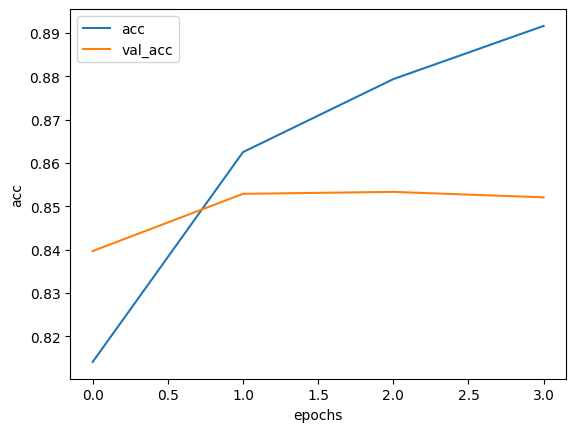

In [103]:
def plot_graph(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history["val_{}".format(metric)], label = "val_{}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    
plot_graph(history, 'acc') # acc : 0.89, val_acc : 0.85

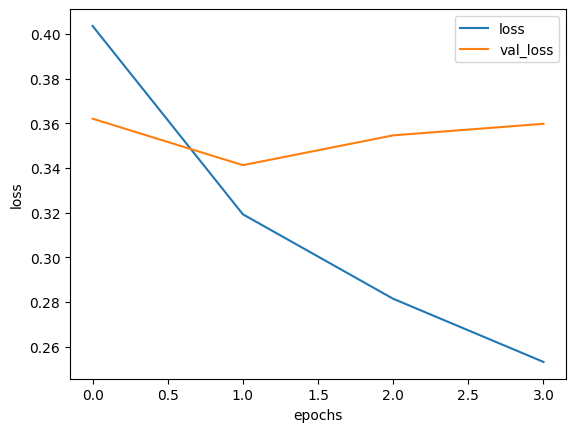

In [104]:
plot_graph(history, 'loss')

### Test Dataset으로 검증
테스트 데이터셋을 불러와서 동일한 전처리 과정을 거친 후, 직접 모델에 적용한다.

In [106]:
test_files = tf.keras.utils.get_file(
    "rating_test.txt",
    origin = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",
    extract=True
)

test = pd.read_csv(test_files, sep = "\t")
test.head()

4893335/4893335 [==============================] - 1s 0us/step


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [107]:
# 데이터 전처리 함수 정의
def preprocessing(df):
    df["document"] = df["document"].str.replace("^[A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ ]", "")
    df = df.dropna()
    test_label = np.asarray(df[['label']])
    test_data = df['document'].apply(lambda x : word_toeknization(x))
    test_data = tokenizer.texts_to_sequences(test_data)

    test_data = pad_sequences(test_data,
                              truncating = trunc_type,
                              padding = padding_type,
                              maxlen = max_length)
    return test_data, test_label

test_data, test_label = preprocessing(test)
print(model.evaluate(test_data, test_label)) # model.evaluate = train 시 마지막 단의 epoch의 지표들을 출력한다.

1563/1563 [==============================] - 25s 16ms/step - loss: 0.4059 - acc: 0.8141
[0.405940443277359, 0.8141446113586426]


### 저장된 모델 불러오기
체크포인트로 저장한 가중치를 불러온다. 비교를 위해 먼저 가중치 적용 전의 모델로 평가하고 이후 저장된 가중치를 적용하여 평가한다.

In [108]:
model2 = create_model()
model2.evaluate(test_data, test_label)

1563/1563 [==============================] - 29s 18ms/step - loss: 0.6934 - acc: 0.4957


[0.6933954358100891, 0.495726615190506]

In [109]:
model2.load_weights(checkpoint_path)
model2.evaluate(test_data, test_label)

1563/1563 [==============================] - 27s 17ms/step - loss: 0.4059 - acc: 0.8141


[0.405940443277359, 0.8141446113586426]

이렇게 학습 시에 저장하는 가중치 파일을 불러와서 검증을 진행하면 정확도가 유지된 상태로 평가를 진행할 수 있다.

### KoBert 토크나이저
SK T-Brain에서 한국어 성능 향상을 위해 개발한 KoBERT 토크나이저가 있다. 덕분에 쉽게 한국어 사전에 학습된 모델과 토큰화를 활용할 수 있다. 순환 신경망 모델은 그대로 활용하고, 토크나이저만 KoBERT를 적용한다. 

In [110]:
!git clone https://github.com/SKTBrain/KoBERT.git

Cloning into 'KoBERT'...


In [2]:
%cd KoBERT

d:\ML_DL\DL\PDT\KoBERT


In [3]:
!pip install -r requirements.txt

  Using cached boto3-1.15.18-py2.py3-none-any.whl (129 kB)
  Using cached gluonnlp-0.10.0.tar.gz (344 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached mxnet-1.7.0.post2-py2.py3-none-win_amd64.whl (33.1 MB)
  Using cached onnxruntime-1.8.0-cp39-cp39-win_amd64.whl (4.7 MB)
  Using cached sentencepiece-0.1.96-cp39-cp39-win_amd64.whl (1.1 MB)
  Using cached transformers-4.8.1-py3-none-any.whl (2.5 MB)
  Using cached botocore-1.18.18-py2.py3-none-any.whl (6.7 MB)
  Using cached jmespath-0.10.0-py2.py3-none-any.whl (24 kB)
  Using cached s3transfer-0.3.7-py2.py3-none-any.whl (73 kB)
  Using cached numpy-1.16.6-cp39-cp39-win_amd64.whl
  Using cached requests-2.18.4-py2.py3-none-any.whl (88 kB)
  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
  Using cached huggingface_hub-0.0.12-py3-none-any.whl (37 kB)
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other 

ERROR: Cannot install -r requirements.txt (line 2), -r requirements.txt (line 3) and -r requirements.txt (line 4) because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
